## Data preparation

In [1]:
from pathlib import Path

# Define the base path and category paths
base_path = Path("/teamspace/studios/this_studio")
categories = ["forehand", "backhand", "serve"]

# Check if each category path exists and list some image files
for category in categories:
    category_path = base_path / category
    if category_path.exists() and category_path.is_dir():
        print(f"Category '{category}' path exists: {category_path}")
        
        # List the first 5 images to ensure they are present
        images = list(category_path.glob("*.jpeg"))[:5]  # Using .jpeg extension
        print(f"Found {len(images)} images in '{category}': {[img.name for img in images]}")
    else:
        print(f"Category '{category}' path does NOT exist: {category_path}")



Category 'forehand' path exists: /teamspace/studios/this_studio/forehand
Found 5 images in 'forehand': ['F_001.jpeg', 'F_002.jpeg', 'F_003.jpeg', 'F_004.jpeg', 'F_005.jpeg']
Category 'backhand' path exists: /teamspace/studios/this_studio/backhand
Found 5 images in 'backhand': ['B_001.jpeg', 'B_002.jpeg', 'B_003.jpeg', 'B_004.jpeg', 'B_005.jpeg']
Category 'serve' path exists: /teamspace/studios/this_studio/serve
Found 5 images in 'serve': ['S_001.jpeg', 'S_002.jpeg', 'S_003.jpeg', 'S_004.jpeg', 'S_005.jpeg']


In [2]:
# Define the base path and category paths
base_path = Path("/teamspace/studios/this_studio")
categories = ["forehand", "backhand", "serve"]

# Initialize a dictionary to store counts
image_counts = {}

# Count images while ignoring "seq" folders
for category in categories:
    category_path = base_path / category
    images = [img for img in category_path.glob("*.jpeg") if not img.parent.name.startswith("seq")]
    image_counts[category] = len(images)
    print(f"Category '{category}' has {image_counts[category]} images (excluding 'seq' folders)")


Category 'forehand' has 500 images (excluding 'seq' folders)
Category 'backhand' has 500 images (excluding 'seq' folders)
Category 'serve' has 500 images (excluding 'seq' folders)


In [3]:
from PIL import Image
import numpy as np

# Define base path and categories
base_path = Path("/teamspace/studios/this_studio")
categories = ["forehand", "backhand", "serve"]

# Initialize lists to store widths and heights
widths, heights = [], []

# Loop through each category and collect image sizes
for category in categories:
    category_path = base_path / category
    images = list(category_path.glob("*.jpeg"))  # Only main folder images, excluding "seq" folders

    for img_path in images:
        with Image.open(img_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

# Calculate the average width and height
average_width = np.mean(widths)
average_height = np.mean(heights)

print(f"Average image width: {average_width:.2f} pixels")
print(f"Average image height: {average_height:.2f} pixels")


Average image width: 1280.00 pixels
Average image height: 720.00 pixels


In [4]:
from PIL import Image
import os

# Define base path, categories, and output directory for resized images
base_path = Path("/teamspace/studios/this_studio")
categories = ["forehand", "backhand", "serve"]
output_path = base_path / "resized_images"
output_path.mkdir(exist_ok=True)

# Resize dimensions
resize_size = (500, 500)

# Loop through each category, resize images, and save to new folder
for category in categories:
    category_path = base_path / category
    resized_category_path = output_path / category
    resized_category_path.mkdir(parents=True, exist_ok=True)
    
    images = list(category_path.glob("*.jpeg"))  # Only main folder images
    
    for img_path in images:
        with Image.open(img_path) as img:
            # Resize and save to the new directory
            img_resized = img.resize(resize_size)
            img_resized.save(resized_category_path / img_path.name)
    
    print(f"Resized images saved in '{resized_category_path}'")


Resized images saved in '/teamspace/studios/this_studio/resized_images/forehand'


KeyboardInterrupt: 

Category: forehand


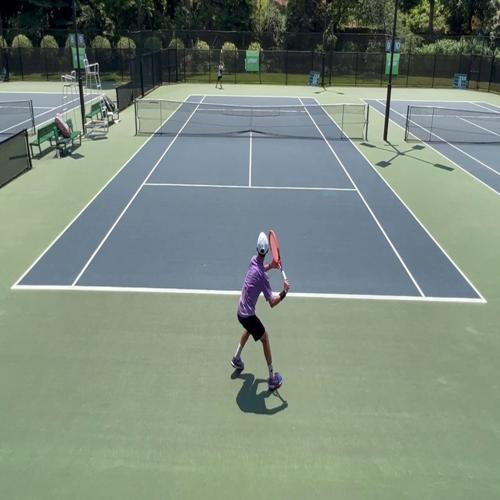

Category: backhand


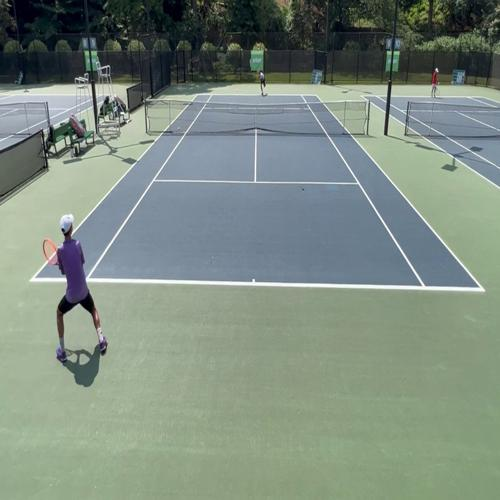

Category: serve


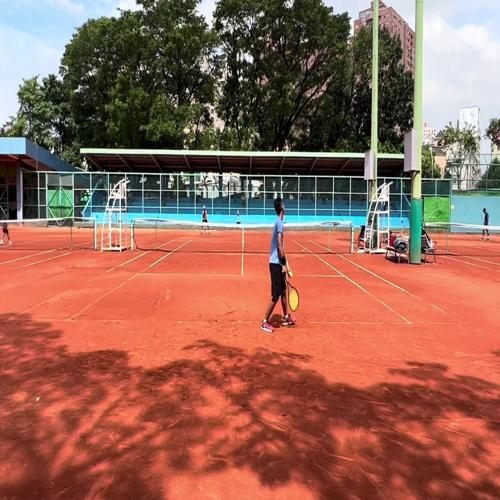

In [ ]:
from IPython.display import display

# Display one resized image from each category
for category in categories:
    resized_category_path = output_path / category
    img_path = next(resized_category_path.glob("*.jpeg"), None)  # Get the first image in the category
    
    if img_path:
        with Image.open(img_path) as img:
            print(f"Category: {category}")
            display(img)


### Normalizing and train test split

In [ ]:
import shutil
import random
from pathlib import Path

# Define directories for train, val, and test sets within the resized_images folder
split_paths = {
    "train": output_path / "train",
    "val": output_path / "val",
    "test": output_path / "test"
}

# Create directories if they don't exist
for split in split_paths.values():
    split.mkdir(parents=True, exist_ok=True)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split resized images for each category
for category in categories:
    resized_category_path = output_path / category
    images = list(resized_category_path.glob("*.jpeg"))
    random.shuffle(images)  # Shuffle images for randomness
    
    # Calculate split sizes
    train_count = int(train_ratio * len(images))
    val_count = int(val_ratio * len(images))
    
    # Split images
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]
    
    # Move images to their respective split folders
    for img_set, split_name in zip([train_images, val_images, test_images], ["train", "val", "test"]):
        split_category_path = split_paths[split_name] / category
        split_category_path.mkdir(parents=True, exist_ok=True)
        
        for img_path in img_set:
            shutil.move(img_path, split_category_path / img_path.name)
    
    print(f"Category '{category}' split into train, val, and test sets.")



Category 'forehand' split into train, val, and test sets.
Category 'backhand' split into train, val, and test sets.
Category 'serve' split into train, val, and test sets.


## Exploratory data analysis

In [7]:
from torchvision import transforms

# Define data augmentation transformations for the training set
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),       # Rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(),    # Randomly flip images horizontally
    transforms.RandomResizedCrop(500, scale=(0.8, 1.2)),  # Slight zoom
    transforms.ToTensor()
])

# Define validation and test transformations without augmentation
val_test_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])



In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Load datasets with transformations
train_dataset = ImageFolder(split_paths["train"], transform=train_transforms)
val_dataset = ImageFolder(split_paths["val"], transform=val_test_transforms)
test_dataset = ImageFolder(split_paths["test"], transform=val_test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


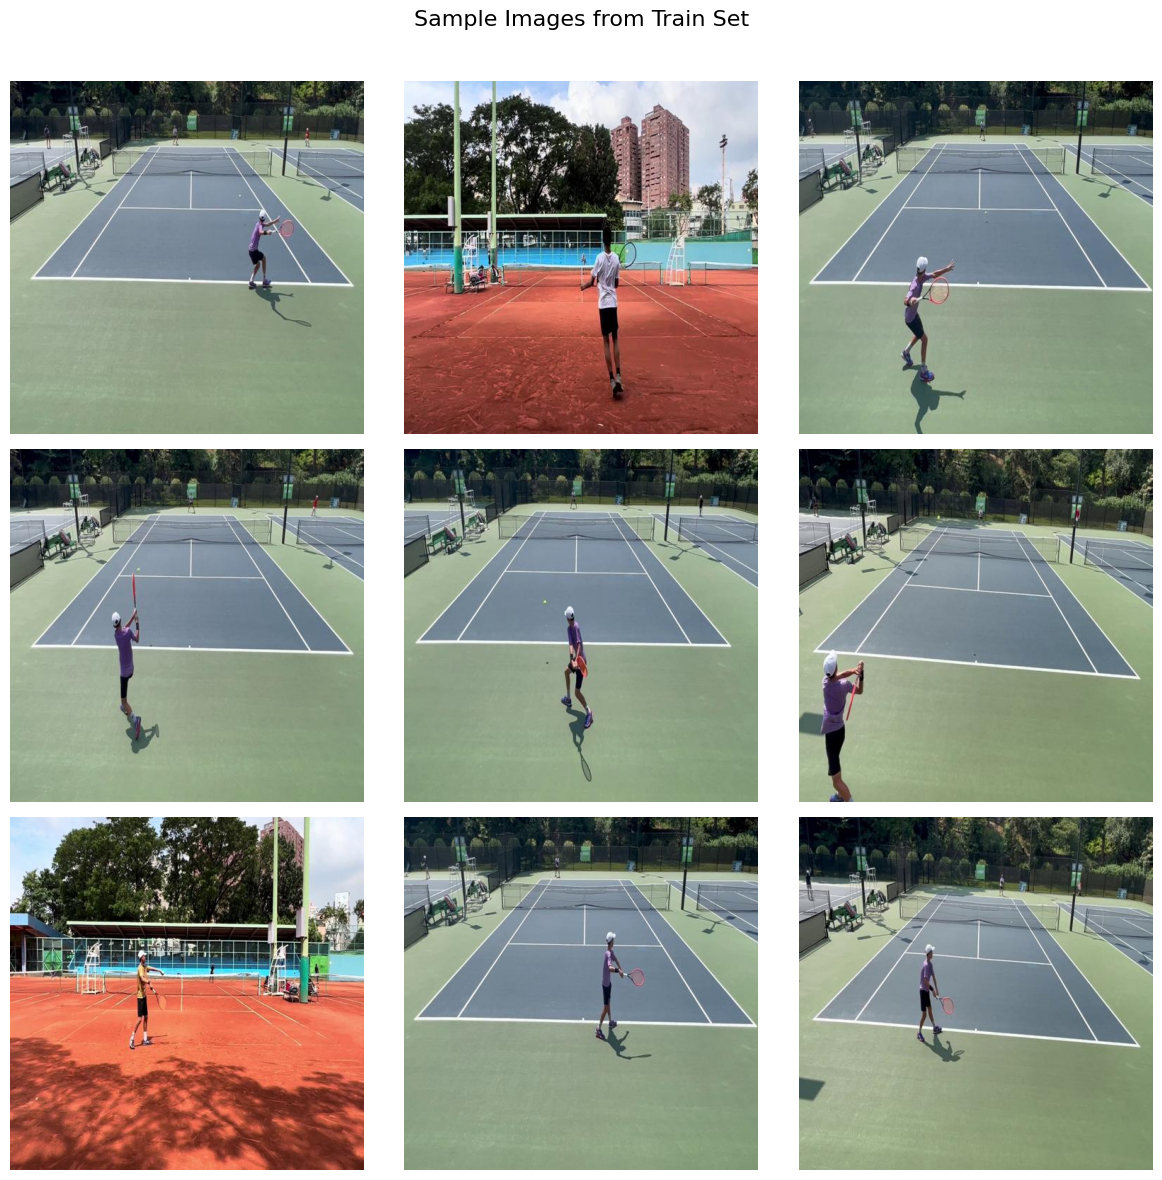

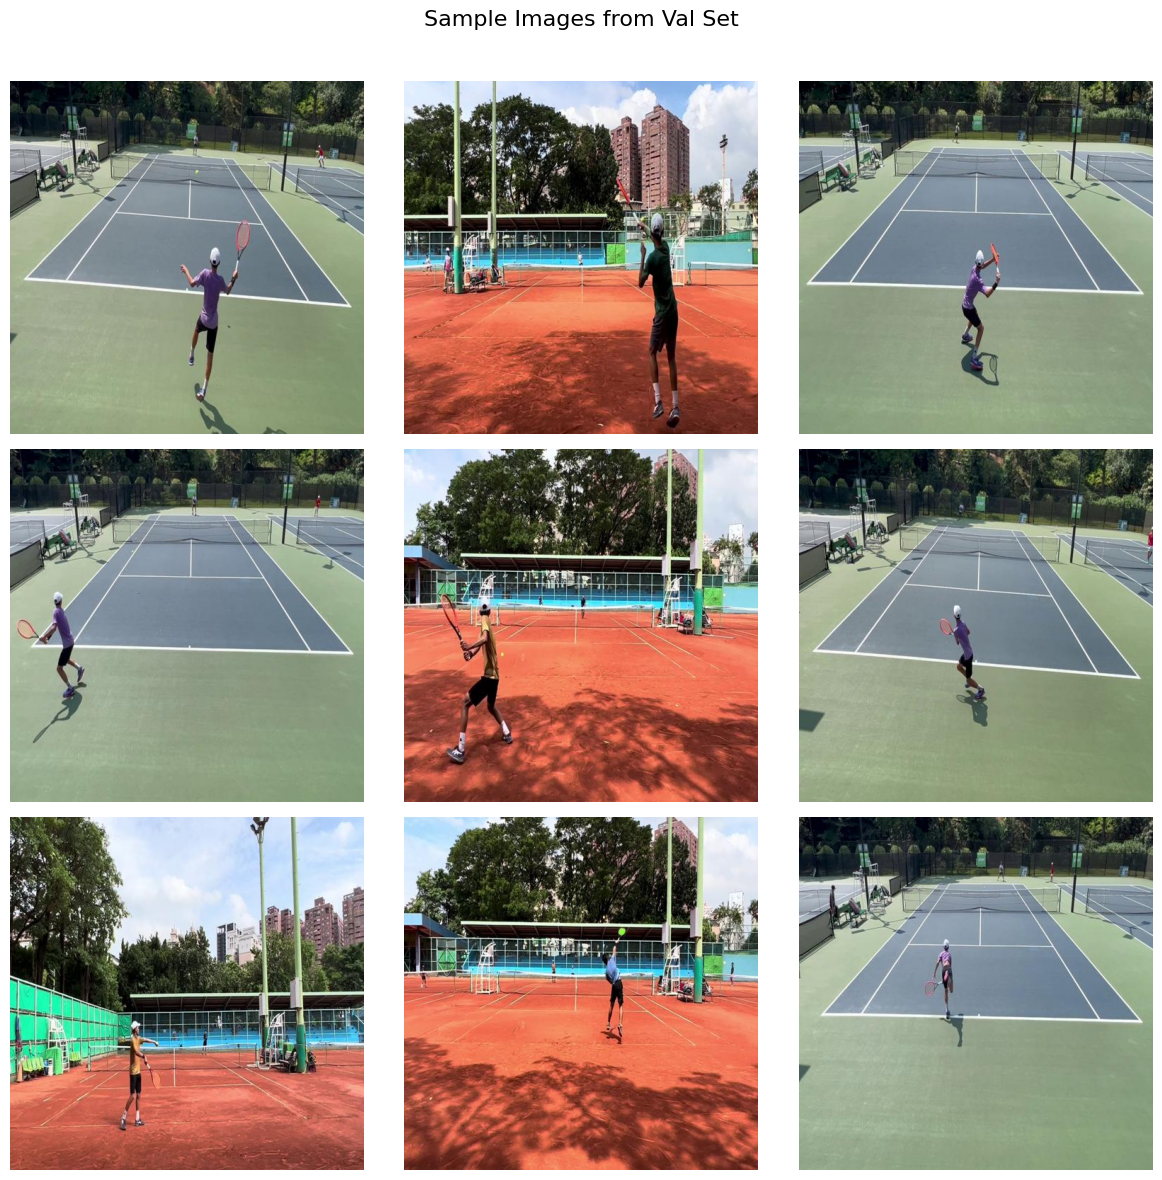

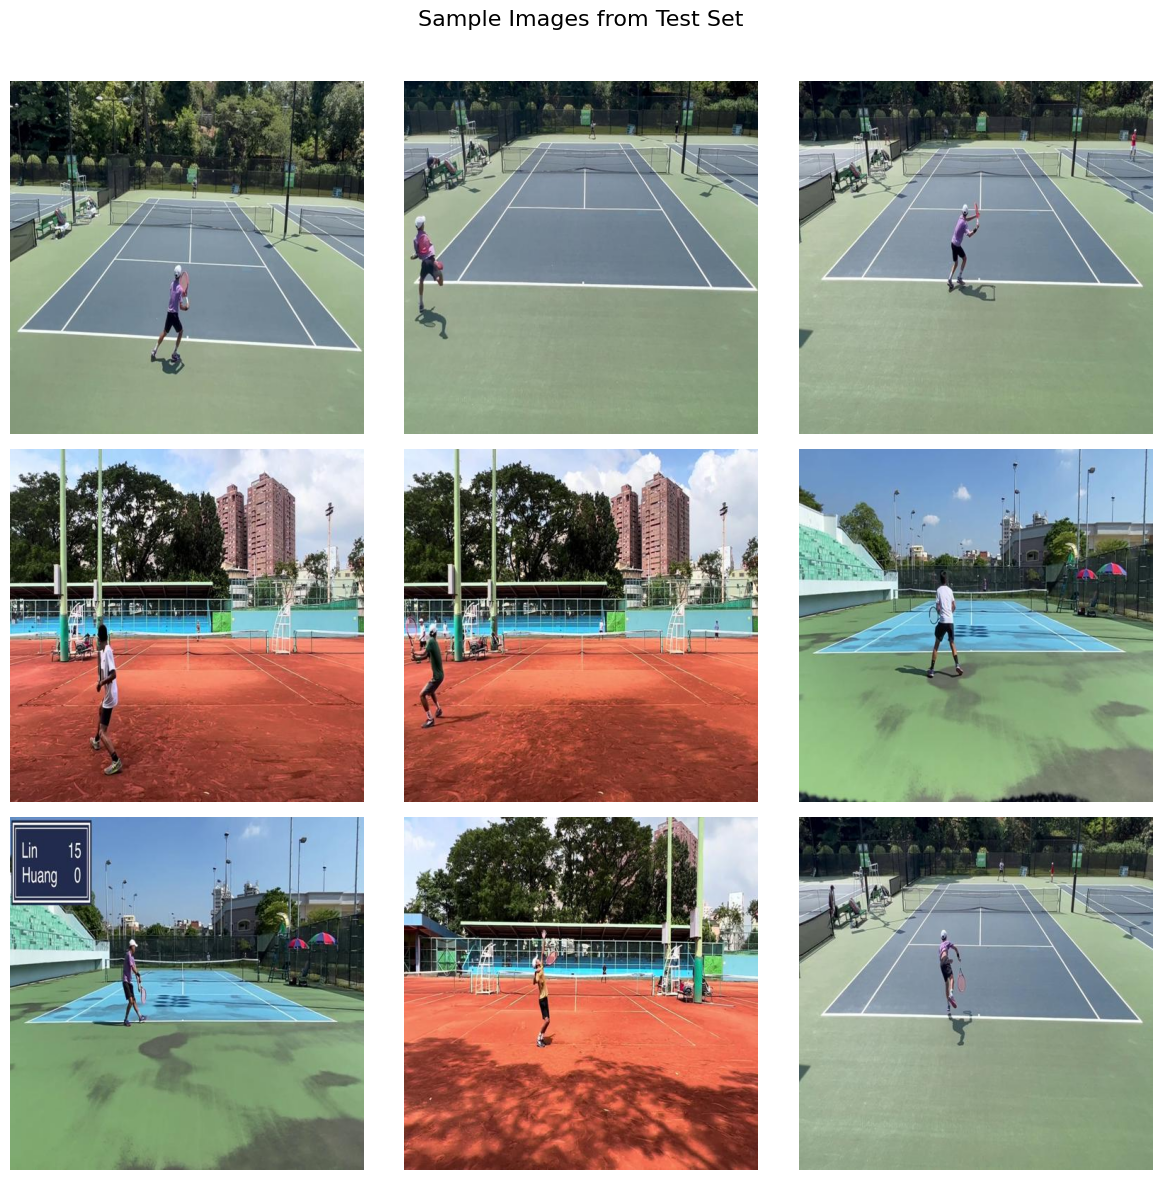

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Function to display sample images from each category and split
def display_samples_from_splits(categories, split_paths, num_samples=3):
    for split_name, split_path in split_paths.items():
        fig, axs = plt.subplots(len(categories), num_samples, figsize=(num_samples * 4, len(categories) * 4))
        fig.suptitle(f"Sample Images from {split_name.capitalize()} Set", fontsize=16)
        
        for i, category in enumerate(categories):
            category_path = split_path / category
            sample_images = list(category_path.glob("*.jpeg"))
            
            # Randomly select images if there are enough, otherwise take all
            if len(sample_images) > num_samples:
                sample_images = random.sample(sample_images, num_samples)
            
            for j, img_path in enumerate(sample_images):
                with Image.open(img_path) as img:
                    axs[i, j].imshow(img)
                    axs[i, j].axis("off")
                    if j == 0:
                        axs[i, j].set_ylabel(category, fontsize=12)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()

# Display samples from each set
display_samples_from_splits(categories, split_paths, num_samples=3)


## Model set up

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 125 * 125, 128)  # 125x125 due to pooling
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 125 * 125)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


num_classes = len(categories)
simple_cnn = SimpleCNN(num_classes)


In [12]:
# Load pre-trained ResNet18
resnet18 = models.resnet18(pretrained=True)

# Modify the final layer for our specific number of classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.001
simple_cnn_optimizer = optim.Adam(simple_cnn.parameters(), lr=learning_rate)
resnet18_optimizer = optim.Adam(resnet18.parameters(), lr=learning_rate)


In [14]:
import torch

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training function
def train_model(model, optimizer, train_loader, val_loader, num_epochs=5):
    model.to(device)  # Move model to GPU

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Move images and labels to GPU
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate accuracy and loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                # Move validation images and labels to GPU
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs = model(val_images)
                _, val_predicted = val_outputs.max(1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy:.2f}%\n")

# Run the training with GPU
# Training the Simple CNN
train_model(simple_cnn, simple_cnn_optimizer, train_loader, val_loader, num_epochs=5)

# Training the ResNet18
train_model(resnet18, resnet18_optimizer, train_loader, val_loader, num_epochs=5)


Using device: cuda


Epoch [1/5], Loss: 2.1404, Accuracy: 32.57%
Validation Accuracy: 30.93%

Epoch [2/5], Loss: 1.0711, Accuracy: 38.86%
Validation Accuracy: 48.02%

Epoch [3/5], Loss: 1.0364, Accuracy: 42.45%
Validation Accuracy: 48.31%

Epoch [4/5], Loss: 1.0032, Accuracy: 46.99%
Validation Accuracy: 56.07%

Epoch [5/5], Loss: 0.9316, Accuracy: 53.76%
Validation Accuracy: 59.75%

Epoch [1/5], Loss: 0.6665, Accuracy: 71.02%
Validation Accuracy: 38.70%

Epoch [2/5], Loss: 0.4350, Accuracy: 81.79%
Validation Accuracy: 87.99%

Epoch [3/5], Loss: 0.3620, Accuracy: 85.71%
Validation Accuracy: 94.35%

Epoch [4/5], Loss: 0.2978, Accuracy: 88.69%
Validation Accuracy: 86.72%

Epoch [5/5], Loss: 0.2287, Accuracy: 91.81%
Validation Accuracy: 84.32%



In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    precision = precision_score(all_labels, all_preds, average='weighted') * 100
    recall = recall_score(all_labels, all_preds, average='weighted') * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")


In [16]:
# Move models to the correct device (GPU or CPU) if not already there
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Evaluating Simple CNN Model:")
evaluate_model(simple_cnn, val_loader, device)

print("\nEvaluating ResNet18 Model:")
evaluate_model(resnet18, val_loader, device)


Evaluating Simple CNN Model:


Accuracy: 59.75%
Precision: 65.94%
Recall: 59.75%
F1 Score: 57.21%

Evaluating ResNet18 Model:
Accuracy: 84.32%
Precision: 87.67%
Recall: 84.32%
F1 Score: 83.75%


## Fine Tuning Resnet

In [17]:
from torchvision import models
import torch.nn as nn

# Load pre-trained ResNet18
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers initially
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of classes
num_classes = len(categories)  # assuming categories is defined as ["forehand", "backhand", "serve"]
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Unfreeze the last layer(s) to allow fine-tuning
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Optionally, unfreeze additional layers (e.g., last residual block)
for param in resnet18.layer4.parameters():
    param.requires_grad = True


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
from torchvision import transforms

# Define data augmentation transformations for the training set
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),            # Rotate images up to 20 degrees
    transforms.RandomHorizontalFlip(),         # Horizontal flip
    transforms.RandomResizedCrop(500, scale=(0.8, 1.2)),  # Random zoom
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
])

# Define basic transformations for validation and test sets
val_test_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])


In [19]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load datasets with transformations
train_dataset = ImageFolder(split_paths["train"], transform=train_transforms)
val_dataset = ImageFolder(split_paths["val"], transform=val_test_transforms)
test_dataset = ImageFolder(split_paths["test"], transform=val_test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with a lower learning rate for fine-tuning
fine_tune_optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=0.0001)


In [21]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs=10, model_name="ResNet18 Fine-Tuned"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Training {model_name} on {device}...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate accuracy and loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
               


In [22]:
# Fine-tune ResNet18 with enhanced training settings
train_model(resnet18, fine_tune_optimizer, train_loader, val_loader, num_epochs=10, model_name="ResNet18 Fine-Tuned")


Training ResNet18 Fine-Tuned on cuda...


ResNet18 Fine-Tuned - Epoch [1/10], Loss: 0.7812, Accuracy: 67.03%
ResNet18 Fine-Tuned - Epoch [2/10], Loss: 0.4023, Accuracy: 84.16%
ResNet18 Fine-Tuned - Epoch [3/10], Loss: 0.2614, Accuracy: 91.33%
ResNet18 Fine-Tuned - Epoch [4/10], Loss: 0.2151, Accuracy: 91.94%
ResNet18 Fine-Tuned - Epoch [5/10], Loss: 0.1744, Accuracy: 93.97%
ResNet18 Fine-Tuned - Epoch [6/10], Loss: 0.1511, Accuracy: 95.33%
ResNet18 Fine-Tuned - Epoch [7/10], Loss: 0.1170, Accuracy: 96.61%
ResNet18 Fine-Tuned - Epoch [8/10], Loss: 0.1301, Accuracy: 96.61%
ResNet18 Fine-Tuned - Epoch [9/10], Loss: 0.1043, Accuracy: 96.75%
ResNet18 Fine-Tuned - Epoch [10/10], Loss: 0.0989, Accuracy: 96.75%


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, device, set_name="Validation"):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    precision = precision_score(all_labels, all_preds, average='weighted') * 100
    recall = recall_score(all_labels, all_preds, average='weighted') * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100

    print(f"{set_name} Set Metrics:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%\n")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(categories)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{set_name} Set Confusion Matrix")
    plt.show()


Evaluating on Training Set:
Training Set Metrics:
Accuracy: 98.58%
Precision: 98.58%
Recall: 98.58%
F1 Score: 98.58%



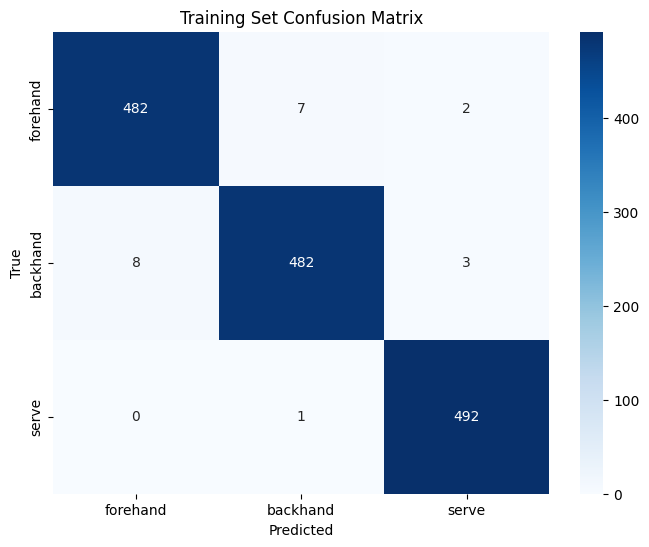


Evaluating on Validation Set:
Validation Set Metrics:
Accuracy: 98.16%
Precision: 98.18%
Recall: 98.16%
F1 Score: 98.16%



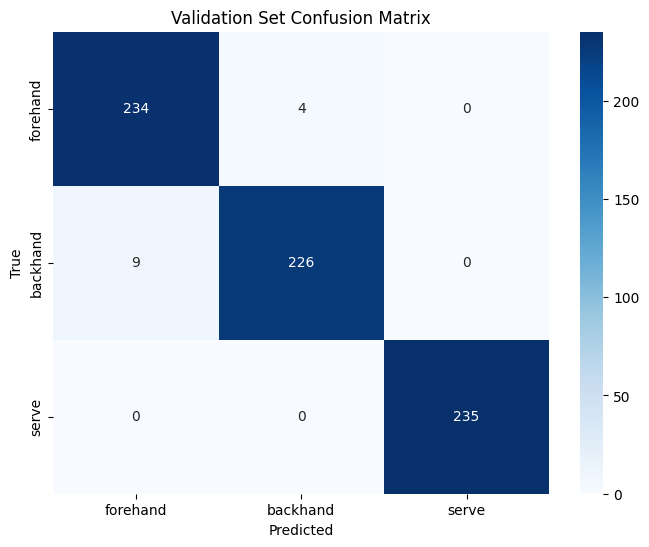

In [27]:
# Assuming `train_loader`, `val_loader`, and `device` are already defined, and `categories` holds class names

# Evaluate on the Training Set
print("Evaluating on Training Set:")
evaluate_model(resnet18, train_loader, device, set_name="Training")

# Evaluate on the Validation Set
print("\nEvaluating on Validation Set:")
evaluate_model(resnet18, val_loader, device, set_name="Validation")


## Final Evaluation on Test Set


In [28]:
!pip install seaborn


Evaluating on Test Set:
Validation Set Metrics:
Accuracy: 98.29%
Precision: 98.31%
Recall: 98.29%
F1 Score: 98.29%



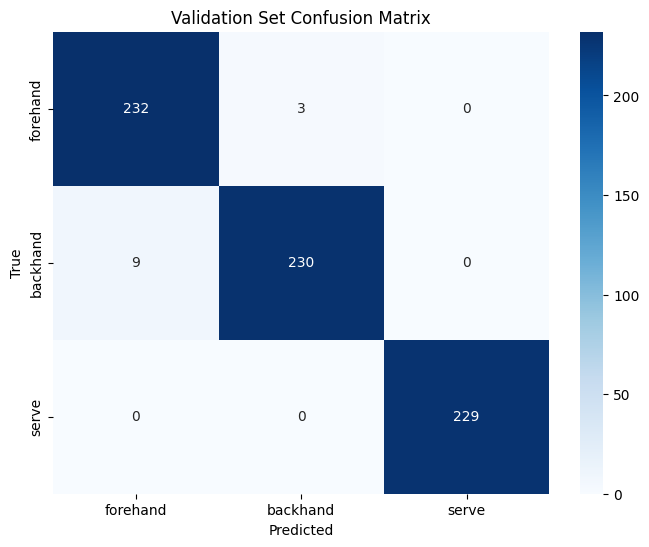

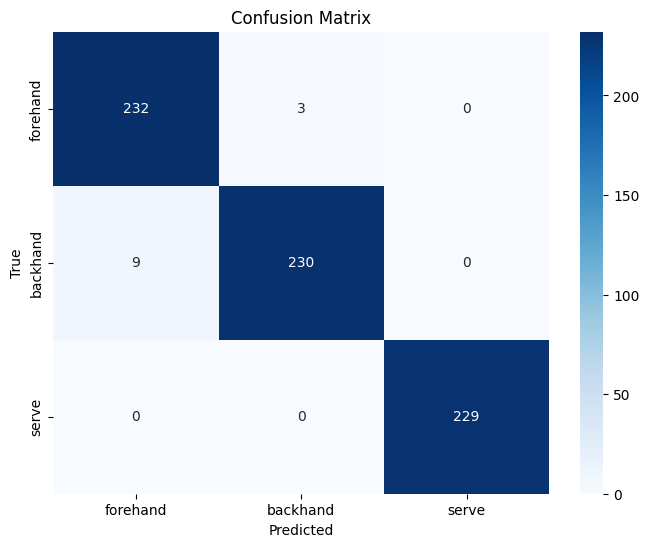

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test set
print("Evaluating on Test Set:")
evaluate_model(resnet18, test_loader, device)

# Generate confusion matrix
def plot_confusion_matrix(model, data_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix for test set
plot_confusion_matrix(resnet18, test_loader)